# PUI2015 FINAL EXAM
### Christopher Prince
### cmp670@nyu.edu

## Goal: evaluate the relevance of different factors in causing asthma in NYC. 

## Motivation: 
Several environmental variables affect respiratory health. The health department finds correlation between asthma cases and a number of geographical factors, including:
proximity to highways, proximity to green spaces, criminality rate (murder rate specifically). Additionally environmental factors such as construction releasing air pollutants, unsanitary conditions, etc., may trigger respiratory problems.
In this work you will attempt to valuate the importance of these factors.


## Method: 

work on the ZIP code level.

1) __Identify the 5 facilities__ that reported the highest incidence of asthma cases and find which ZIP code they fall in.

2) __Develop a Metric__ for each of the fllowing: access to green space, murder rate, environmental health, and proximity to highways for each ZIP code (no panic, suggestions on how to proceed are in the hints file). You must choose AT LEAST 2 variables among these 4. We encourage you to work with three. Choosing 4 or more, and coming up with additional ones, is considered extra credit.

3) __Show a table__ containing the value of each variable of interest for the 5 ZIP codes corresponding to the highest cases of Asthma.

4) __Display__ each of your metrics as a choropleth (a heatmap version of a geographical map where each zip code is a different color based on the value of the metric you are mapping).

5) __Fit__ a model  (try a multivariate linear model for example or any other model which you think may be reasonable, keeping in mind you will need to use the model in the last task) to the incidence of asthma cases per NYC ZIP code (this is your dependent variable) as a function of variables mentioned above, based on the ZIP codes of the top 5 facilities reporing asthma. 

6) __Cluster__ the ZIP codes using the model you generated in step 4 as a distance metric (suggestions if needed are in the hints file).

7) __Discuss__. What did you find? What is the spatial coherence of the different factors considered, which variables seem to be more important in triggering asthma cases, what are the weaknesses of the model, how does the clustering look. 




First, setups for imports and the pyplot magic word.

In [1]:
%matplotlib inline

#http processing
import ast
import json
import os
import urllib
import urllib2
from cStringIO import StringIO

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.cluster import KMeans, SpectralClustering, Birch, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import geopandas as gpd
import pylab as pl
import textwrap

Here's a section of the plotting parameter file so that I don't have to reset font sizes for every plot.

In [2]:
rcp = '''
{
  "lines.linewidth": 1.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 1.0,
  "legend.fancybox": true,
  "axes.color_cycle": [
    "SteelBlue",
    "IndianRed",
    "Green",
    "DarkOrange",
    "MediumTurquoise",
    "gold",
    "#E24A33"
  ],
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "x-large",
  "xtick.labelsize": "x-large",
  "ytick.labelsize": "x-large",
  "axes.grid": false,
  "axes.titlesize": "x-large",
  "svg.embed_char_paths": "path",
  "examples.directory": ""
}
'''
s = json.loads(rcp)
pl.rcParams.update(s)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


While we're at it, let's set the nupmy random seed so that clustering will be reproducible:

In [3]:
np.random.seed(11215)


<h1> Task 1: Querying Asthma Discharges </h1>

In this first task, you are to asked to retrieve the top 5 facility IDs that had the highest count of asthma treatments in 2013. We can assume that any case that is diagnosed as an Asthma treatment should have the word "*asthma*" (case-insensitive) in the **ccs_diagnosis_description** of the **nyc_discharge_2013**. This must be done through a SQL command.
In the data section we define a helper function <b>queryCartoDB</b> to wrap around the SQL API of CartoDB. We can simply pass in a public data source (in the form of 'https://{ACCOUNT}.cartodb.com/api/v2/sql', where ACCOUNT is the owner of the data) and a SQL statement for us to query the data in various formats including CSV, JSON, and GeoJSON. There will be three data sources (with table name in parentheses) to be queried from the CartoDB databases: so that you canget data for the New York City Hospital Inpatient 2013 Discharge, Health Facility Information, Highway streets per zip code.

Examples and bits of code you can use are provided in the PUI2015_DATA.ipynb (you can copy an paste code from there into this notebook)

After retrieveing those 5 IDs, please cross-reference them with the IDs listed in the **nyc_facility** table (this could be done with SQL or offline with GeoPandas using the **facilities** variable above). Then provide us with the following:

<ol>
<li>The list the top 5 facilities by their facility names (aka. the **facility_name** column)</li>
<li>A map of those 5 facilities in the NAD 83 / New York Long Island (EPSG:2263) coordiantes.</li>

Here is the helper function from the data file that accesses Dr. Vo's cartodb data:

In [4]:
SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

How big is the discharge set? Maybe we can just download the entire table?

In [5]:
dischargeQuery = '''
SELECT COUNT(*)
FROM nyc_discharge_2013
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream)
discharge.head()

,count,Unnamed: 1
0,1132059,NaN


Okay, maybe not with 1.1 million rows. So let's do this the way you probably intended and use queries to answer the question. First, get the top five facilities by ID that contain the word "asthma":

In [6]:
dischargeQuery = '''
SELECT facility_id, count(facility_id) AS count_diagnoses
FROM nyc_discharge_2013
WHERE ccs_diagnosis_description ILIKE ('%asthma%')
GROUP BY facility_id
ORDER BY COUNT(facility_id) DESC
LIMIT 5
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream)
discharge

,facility_id,count_diagnoses
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


Okay, now we have the facility IDs. Now we need to match them to their names. So let's get the table columns.

In [7]:
facilityQuery = '''
SELECT *
FROM nyc_facilities
LIMIT 3
'''

facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])
facilities.columns

Index([                  u'cartodb_id',           u'cooperator_address',
               u'cooperator_address_2',              u'cooperator_city',
                    u'cooperator_name',             u'cooperator_state',
                u'cooperator_zip_code',                  u'description',
                 u'facility_address_1',           u'facility_address_2',
                      u'facility_city',              u'facility_county',
               u'facility_county_code',          u'facility_fax_number',
                        u'facility_id',            u'facility_latitude',
                  u'facility_location',           u'facility_longitude',
                      u'facility_name',           u'facility_open_date',
              u'facility_phone_number',               u'facility_state',
                   u'facility_website',            u'facility_zip_code',
                           u'geometry',        u'main_site_facility_id',
                     u'main_site_name', u'operating

Now I need to create a string of the IDs that I can pass to the WHERE clause of an SQL query to the facility table:

In [8]:
id_string = ', '.join(map(str, list(discharge.facility_id)))

In [9]:
id_string

'1172, 1169, 1301, 1165, 1178'

So now I can get the names of the facilities:

In [10]:
facilityQuery = '''
SELECT facility_name, facility_id, facility_zip_code, the_geom
FROM nyc_facilities
WHERE facility_id IN ({})

'''.format(id_string)

facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])

It'll be convenient to change the zipcode field to `zipcode`.

In [11]:
facilities.rename(columns={'facility_zip_code': 'zipcode'}, inplace=True)

## `***` HERE IS THE ANSWER TO THE FIRST PART OF THIS TASK: `***`

In [12]:
#pandas by default truncates after 50 charaters; we just need a few more
#to display the full names
pd.set_option('display.max_colwidth', 60)

#print series as a data frame for prettyprinting
facilities.facility_name.to_frame()

,facility_name
0,Jacobi Medical Center
1,Montefiore Medical Center - Henry & Lucy Moses Div
2,Lincoln Medical & Mental Health Center
3,Bronx-Lebanon Hospital Center - Concourse Division
4,Kings County Hospital Center


Now I need to convert the coordinate reference system to EPSG2263.

I'm going to merge/join data frames a lot, and geoPandas drops the CRS every time. So here I save it so that I can reset it (and all frames in this workbook) to be identical.

In [13]:
init_CRS = {'init': 'epsg:4326', 'no_defs': True}

In [14]:
facilities.crs = init_CRS
facilities.to_crs(epsg = 2263, inplace = True)

In [15]:
facilities.head()

,facility_id,facility_name,zipcode,geometry
0,1165,Jacobi Medical Center,10461,POINT (1026645.436320588 251684.2060465237)
1,1169,Montefiore Medical Center - Henry & Lucy Moses Div,10467,POINT (1017278.463616514 259890.221163824)
2,1172,Lincoln Medical & Mental Health Center,10451,POINT (1005228.021716391 237182.1691768789)
3,1178,Bronx-Lebanon Hospital Center - Concourse Division,10457,POINT (1008724.037560453 246639.2619315821)
4,1301,Kings County Hospital Center,11203,POINT (999760.5456509431 178215.3371727151)


In [16]:
facilities = facilities.merge(discharge, on='facility_id')

In [17]:
facilities.head()

,facility_id,facility_name,zipcode,geometry,count_diagnoses
0,1165,Jacobi Medical Center,10461,POINT (1026645.436320588 251684.2060465237),920
1,1169,Montefiore Medical Center - Henry & Lucy Moses Div,10467,POINT (1017278.463616514 259890.221163824),1786
2,1172,Lincoln Medical & Mental Health Center,10451,POINT (1005228.021716391 237182.1691768789),1878
3,1178,Bronx-Lebanon Hospital Center - Concourse Division,10457,POINT (1008724.037560453 246639.2619315821),890
4,1301,Kings County Hospital Center,11203,POINT (999760.5456509431 178215.3371727151),1057


Now I get the zipcode data:

In [18]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40.60889, -7...",23.486470,10314
1,2,"(POLYGON ((-73.980886 40.75927, -73.98042599999999 40.75...",0.000000,10112
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40.710135, -...",1.447405,10048
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.755243, -73...",0.000000,10171
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40.755303, -...",0.000000,10172


Don't need the cartodb_id anymore:

In [19]:
zipcodes = zipcodes.drop('cartodb_id', axis = 1)

Same conversion for the zipcodes frame:

In [20]:
zipcodes.crs = init_CRS
zipcodes.to_crs(epsg = 2263, inplace = True)

## `***` HERE IS THE ANSWER TO THE SECOND PART OF THIS TASK: `***`

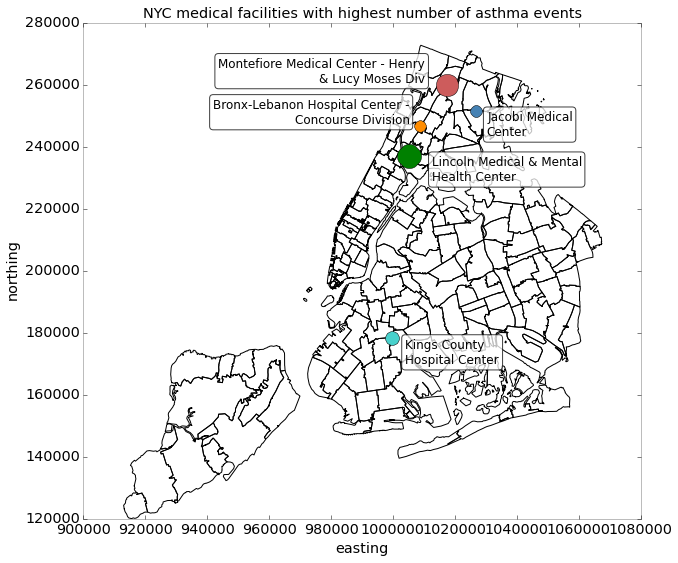

In [21]:
fig = pl.figure(figsize=(10,10))
ax = gpd.plotting.plot_dataframe(zipcodes, alpha=0)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
for i, pt in facilities.iterrows():
    marker_size = pt.count_diagnoses/80.
    ax.text(pt.geometry.x + \
              ax.transAxes.transform((marker_size/2., 0))[0] * 2 * ((i+1)%2 - 0.5),
            pt.geometry.y, 
            textwrap.fill(pt.facility_name, len(pt.facility_name)/1.5),
            horizontalalignment = ['left','right'][i%2], 
            verticalalignment = ['top','bottom'][i%2],
            size = 12, bbox = props)
    gpd.plotting.plot_point(ax, pt.geometry, markersize=marker_size)
ax.set_xlabel('easting')
ax.set_ylabel('northing')
ax.set_title('NYC medical facilities with highest number of asthma events')

**CAPTION**: The location of the five facilities with the highest number of asthma admittances in the discharge data set. The points are sized according to the number of admittances.


<h1> Task 2: Geo-referencing the facilities with the zip code highway profile</h1>

In this task, you are to asked to find out which zip code the top 5 facilities found in Task 1 belong to, and how many miles of highway streets are within its proximity. To determine which zip code a facility belongs to, you can either use SQL or GeoPandas. Your results have to be 

<ol>
<li>a list of 5 facilities (like in Task 1.1) but with two additional columns: the ZIP code and the total highway miles belonging to that zip code.</li>
<li> a map (cloropleth) of highway length for all NYC ZIP codes.
</li>

In [22]:
facilities.columns

Index([u'facility_id', u'facility_name', u'zipcode', u'geometry',
       u'count_diagnoses'],
      dtype='object')

In [23]:
facilities = facilities.merge(zipcodes, how='inner', on='zipcode')

## `***` HERE IS THE ANSWER TO THE FIRST PART OF THIS TASK `***`

In [24]:
pd.DataFrame([facilities.facility_name, 
              facilities.zipcode, 
              facilities.highway_length]).T

,facility_name,zipcode,highway_length
0,Jacobi Medical Center,10461,18.1023
1,Montefiore Medical Center - Henry & Lucy Moses Div,10467,19.172
2,Lincoln Medical & Mental Health Center,10451,7.91418
3,Bronx-Lebanon Hospital Center - Concourse Division,10457,5.0172
4,Kings County Hospital Center,11203,2.21284


Joris van den Bossche has written a modified version of the data frame mapping routine that places a legend on the map. (I found this useful for my Civic Analytics paper.)

Source: http://nbviewer.ipython.org/gist/jorisvandenbossche/d4e6efedfa1e4e91ab65

**NOTE** I'm copying these three cells and only line-breaking them; remaining PEP-8 compliance lies with the original author (but since he's one of the main gpd contributors, I'm guessing it's probably in pretty good shape already).

In [25]:
def __pysal_choro(values, scheme, k=5):
    """ Wrapper for choropleth schemes from PySAL for use with plot_dataframe

        Parameters
        ----------

        values
            Series to be plotted

        scheme
            pysal.esda.mapclassify classificatin scheme 
            ['Equal_interval'|'Quantiles'|'Fisher_Jenks']

        k
            number of classes (2 <= k <=9)

        Returns
        -------

        values
            Series with values replaced with class identifier if PySAL is available, 
            otherwise the original values are used
    """

    try:
        from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        s0 = scheme
        scheme = scheme.lower()
        if scheme not in schemes:
            scheme = 'quantiles'
            print('Unrecognized scheme: ', s0)
            print('Using Quantiles instead')
        if k < 2 or k > 9:
            print('Invalid k: ', k)
            print('2<=k<=9, setting k=5 (default)')
            k = 5
        binning = schemes[scheme](values, k)
        values = binning.yb
    except ImportError:
        print('PySAL not installed, setting map to default')

    return binning

In [26]:
# adding linewidth parameter

def plot_polygon(ax, poly, facecolor='red', edgecolor='black', 
                 alpha=0.5, linewidth=1):
    """ Plot a single Polygon geometry """
    from descartes.patch import PolygonPatch
    a = np.asarray(poly.exterior)
    # without Descartes, we could make a Patch of exterior
    ax.add_patch(PolygonPatch(poly, facecolor=facecolor, alpha=alpha))
    ax.plot(a[:, 0], a[:, 1], color=edgecolor, linewidth=linewidth)
    for p in poly.interiors:
        x, y = zip(*p.coords)
        ax.plot(x, y, color=edgecolor, linewidth=linewidth)

def plot_multipolygon(ax, geom, facecolor='red', edgecolor='black', 
                      alpha=0.5, linewidth=1):
    """ Can safely call with either Polygon or Multipolygon geometry
    """
    if geom.type == 'Polygon':
        plot_polygon(ax, geom, facecolor=facecolor, 
                     edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)
    elif geom.type == 'MultiPolygon':
        for poly in geom.geoms:
            plot_polygon(ax, poly, facecolor=facecolor, 
                         edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)

In [27]:
import numpy as np
from geopandas.plotting import (plot_linestring, plot_point, norm_cmap)


def plot_dataframe(s, column=None, colormap=None, alpha=0.5,
                   categorical=False, legend=False, axes=None, scheme=None,
                   k=5, linewidth=1):
    """ Plot a GeoDataFrame

        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.  Otherwise, a categorical plot of the
        geometries in the `geometry` column will be generated.

        Parameters
        ----------

        GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.

        column : str (default None)
            The name of the column to be plotted.

        categorical : bool (default False)
            If False, colormap will reflect numerical values of the
            column being plotted.  For non-numerical columns (or if
            column=None), this will be set to True.

        colormap : str (default 'Set1')
            The name of a colormap recognized by matplotlib.

        alpha : float (default 0.5)
            Alpha value for polygon fill regions.  Has no effect for
            lines or points.

        legend : bool (default False)
            Plot a legend (Experimental; currently for categorical
            plots only)

        axes : matplotlib.pyplot.Artist (default None)
            axes on which to draw the plot

        scheme : pysal.esda.mapclassify.Map_Classifier
            Choropleth classification schemes

        k   : int (default 5)
            Number of classes (ignored if scheme is None)


        Returns
        -------

        matplotlib axes instance
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import Normalize
    from matplotlib import cm

    if column is None:
        return plot_series(s.geometry, colormap=colormap, 
                           alpha=alpha, axes=axes)
    else:
        if s[column].dtype is np.dtype('O'):
            categorical = True
        if categorical:
            if colormap is None:
                colormap = 'Set1'
            categories = list(set(s[column].values))
            categories.sort()
            valuemap = dict([(k, v) for (v, k) in enumerate(categories)])
            values = [valuemap[k] for k in s[column]]
        else:
            values = s[column]
        if scheme is not None:
            binning = __pysal_choro(values, scheme, k=k)
            values = binning.yb
            # set categorical to True for creating the legend
            categorical = True
            binedges = [binning.yb.min()] + binning.bins.tolist()
            categories = ['{0:.2f} - {1:.2f}'.format(
                            binedges[i], binedges[i+1]) for i in range(len(binedges)-1)]
        cmap = norm_cmap(values, colormap, Normalize, cm)
        if axes == None:
            fig = plt.gcf()
            fig.add_subplot(111, aspect='equal')
            ax = plt.gca()
        else:
            ax = axes
        for geom, value in zip(s.geometry, values):
            if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
                plot_multipolygon(ax, geom, facecolor=cmap.to_rgba(value), 
                                  alpha=alpha, linewidth=linewidth)
            elif geom.type == 'LineString' or geom.type == 'MultiLineString':
                plot_multilinestring(ax, geom, color=cmap.to_rgba(value))
            # TODO: color point geometries
            elif geom.type == 'Point':
                plot_point(ax, geom, color=cmap.to_rgba(value))
        if legend:
            if categorical:
                patches = []
                for value, cat in enumerate(categories):
                    patches.append(Line2D([0], [0], linestyle="none",
                                          marker="o", alpha=alpha,
                                          markersize=10, 
                                          markerfacecolor=cmap.to_rgba(value)))
                ax.legend(patches, categories, numpoints=1, loc='best')
            else:
                # TODO: show a colorbar
                raise NotImplementedError

    plt.draw()
    return ax

## `***` HERE IS THE ANSWER TO THE SECOND PART OF THE TASK `***`

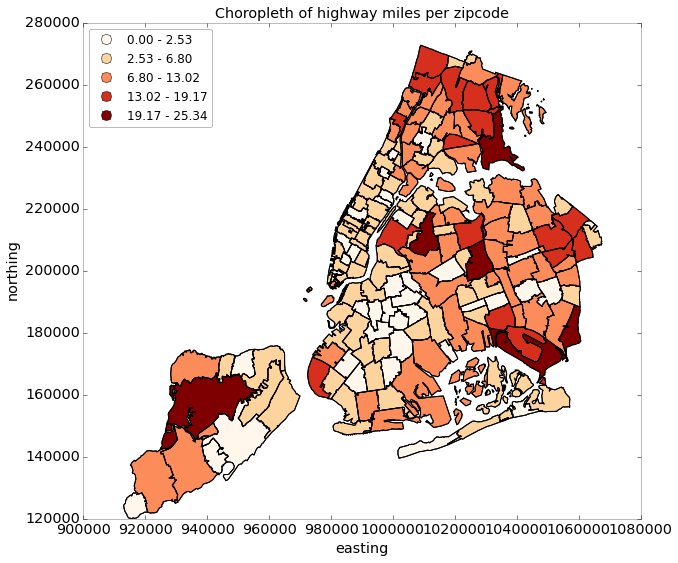

In [28]:
fig = pl.figure(figsize=(10,10))
ax = plot_dataframe(zipcodes, column='highway_length', k = 5, 
                    scheme='fisher_jenks', colormap='OrRd', alpha=1, 
                    legend = True)

ax.set_xlabel('easting')
ax.set_ylabel('northing')
ax.set_title('Choropleth of highway miles per zipcode')

**CAPTION**: Choropleth showing the relative number of highway miles in each zip code. The darker colors are associate with larger values. High values can be seen in the Bronx (cf. Cross-Bronx, Hutch, Bruckner, 895), near JFK (cf. Belt Parkway, Van Wyck), and in Staten Island (cf. 278/440). Note that the BQE, West Side Highway, and the FDR don't show up here; this may be a function of how the zip code geographies lie and their sizes. A better metric for this visualization might be length of highway *per area* of zipcode.

<h2> Of the following 3 tasts (3-5) you must complete at least one, whichever one you prefer, so that you have at least 2 variables for your regressoin (complete one of tasks 3-5 and move to tasks 6 and 7, which are mandatory). However we recommand you then go back, once you are sure you can complete the exercize, and complete more taks to create a more sophisticated model.</h2>


<h1>TASK 3:</h1>
    
   Murder rate: find the murder rate per precinct in NYC and the precinct geographical location (see PUI2015_DATA.ipynb). Design an appropriate metric that describes the exposure to violent crimes (specifically murder) per ZIP code. This should take into account the murder rate as well as the distance to the precint where the murder occurred (suggestions on how to build the metric are in the hints file).
   Your results should be: 
    
   <ol>
    <li>a dataframe like the one derived in TASK 2 but with an additional column: the exposure to violent crimes in the ZIP code of the 5 identified facilities.</li>
    <li> choropleth of the murder rate  for all ZIP codes in NYC</li>
    
 
    

### *My plan to allocate murders to zip codes:*

I will allocate the murders in precincts to a zip code by the proportion of each precinct area covered by the zip code. This will be a little more diffifcult than averaging over an n-nearest metric, but I believe it will give a more accurate representation by zip code because it avoids any peculiarities of precinct shape sizes or non-convexity that may cause included precincts to have centroids located far away. Note that I am making the assumption that the distribution of murders in a precinct is homogeneous. This may not be accurate, but it's also not captured in a centroid model, so I don't think I'm doing any *worse* with this.

First, I import the data. I peeked ahead to see that I need to skip the first two rows of the spreadsheet before getting to the header row.

In [29]:
crime_url = 'http://www.nyc.gov/html/nypd/downloads/excel/analysis_and_planning/seven_major_felony_offenses_by_precinct_2000_2014.xls'

#url = 'https://nycopendata.socrata.com/views/%s' % (dataID)
#request = urllib2.urlopen(crime_url)
crime = pd.read_excel(crime_url, skiprows=2)

We strip the dataset by crime type (the `(?i)` portion of the string indicates that the regular expression should be evaluated as case-insensitive) and assign it to the new frame murders:

In [30]:
murders = crime[crime.CRIME.str.contains('(?i)murder') == True]

All of the precincts looks like they should have been carried over in this operation (only the top crime, murder, had the precincts explicitly listed) but let's check:

In [31]:
murders.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3,1,2,2,2,0,1,0,1,2,2,0,1,0,0
8,5,MURDER & NON NEGL. MANSLAUGHTER ...,4,3,0,3,1,4,2,2,2,1,1,0,3,3,2
16,6,MURDER & NON NEGL. MANSLAUGHTER ...,0,1,0,1,3,1,3,5,0,1,1,1,1,2,2
24,7,MURDER & NON NEGL. MANSLAUGHTER ...,0,3,5,6,3,7,4,2,3,2,1,5,0,1,0
32,9,MURDER & NON NEGL. MANSLAUGHTER ...,3,2,1,3,4,2,1,0,3,4,4,1,1,2,2


Now we import the shape file (unzipped in the home directory):

In [32]:
precincts = gpd.read_file('nypp.shp')

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.



In [33]:
precincts.shape

(77, 4)

These warnings indicate there may be some invalid geometries I'll need to deal with. We'll get to that shortly.

Next I apply the zipcode crs to the precint geometry:

In [34]:
precincts.to_crs(zipcodes.crs, inplace = True)

Next I merge the murder data into the precinct geometry and reassign it to the murder frame:

In [35]:
murders = precincts.merge(murders, how='inner', left_on = 'Precinct', right_on = 'PCT')

We don't need the redundant PCT column, so we drop it:

In [36]:
murders.drop('PCT', axis=1, inplace = True)

murders inherits the CRS from precincts:

In [37]:
murders.crs = precincts.crs

To validate my method of allocation, I need to see what the precinct map looks like for comparison later on:

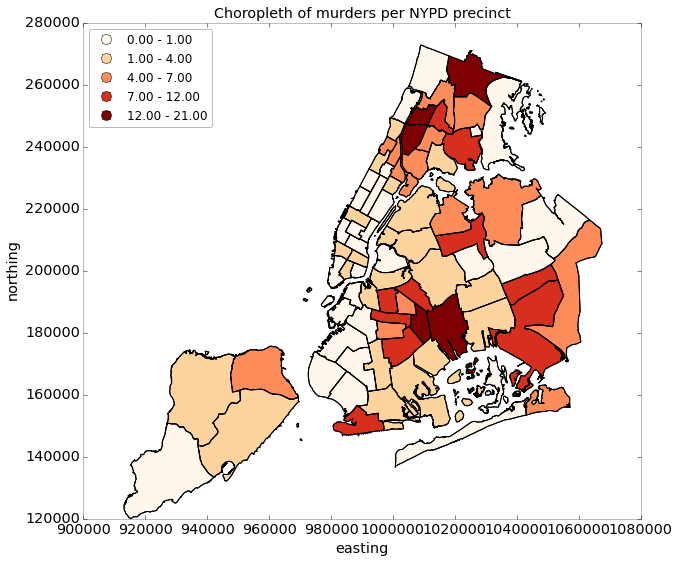

In [38]:
fig = pl.figure(figsize = (10,10))
ax = plot_dataframe(murders, column = 2014, k = 5, 
                    scheme = 'fisher_jenks', colormap = 'OrRd', 
                    alpha = 1, legend = True)
ax.set_xlabel('easting')
ax.set_ylabel('northing')
ax.set_title('Choropleth of murders per NYPD precinct')

So I'm looking for hotspots in Eastern Brooklyn and the area of the Bronx abutting Northern Manhattan. Western Brooklyn and Central and Southern Manhattan should show very low levels of murder.

Now that the geometry is in the murders frame, let's check out those invalid geometries:

In [39]:
murders[~murders.is_valid]

,Precinct,Shape_Area,Shape_Leng,geometry,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
35,61,1.346352e+08,128323.272062,"(POLYGON ((1013340.182434081 149419.9524046623, 1013377....",MURDER & NON NEGL. MANSLAUGHTER ...,6,4,9,10,2,7,6,4,6,3,6,14,3,2,2
70,113,3.896370e+08,214332.334661,"(POLYGON ((1043998.217407226 164496.820446656, 1044015.1...",MURDER & NON NEGL. MANSLAUGHTER ...,12,10,14,17,17,13,6,13,15,12,19,17,16,7,9


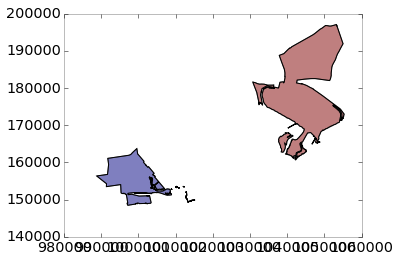

In [40]:
gpd.GeoDataFrame(murders[~murders.is_valid]).plot()

These complicated shapes probably have self-intersections that cause them to be invalid. Fortunately, applying `buffer(0)` fixes this problem with minimal difference in the geometry:

In [41]:
gpd.GeoDataFrame(murders[~murders.is_valid]).buffer(0).is_valid

35    True
70    True
dtype: bool

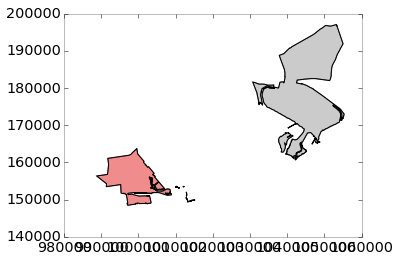

In [42]:
gpd.GeoDataFrame(murders[~murders.is_valid]).buffer(0).plot()

This lets me find intersections between precincts and zipcodes; for example (zipcodes.iloc[0] corresponds to an area of Staten Island):

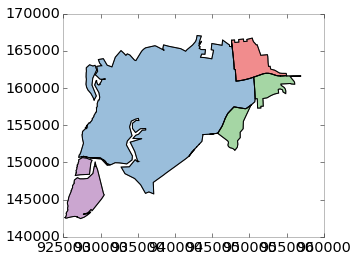

In [43]:
murders.buffer(0).geometry.intersection(zipcodes.iloc[0].geometry).plot()

Four different precincts cover this zipcode. From here it's easy to calculate the fractional area of each precinct included in the zipcode:

In [44]:
pct_subareas = murders.buffer(0).geometry.intersection(zipcodes.iloc[0].geometry).area/ \
    murders.buffer(0).area
pct_subareas[pct_subareas!=0]

73    0.093415
74    0.602237
75    0.057537
76    0.055142
dtype: float64

To calculate the number assigned to the zip code, then, I need to take the dot product of my fractional area vector with the vector of murders per precinct:

In [45]:
print murders[2014].tail(4)
np.dot(pct_subareas, murders[2014])

73    7
74    4
75    3
76    1
Name: 2014, dtype: float64


3.2906107557808317

Okay, enough explanation. Now I write a routine to calculate areas for each then use those to calculate a weighted sum of murders per zipcode. I load them into a dictionary for later creation of a dataframe to merge. This'll take a minute.

In [46]:
murders_perzip = {}

for i, row in zipcodes.iterrows():
    pct_subareas = murders.buffer(0).geometry.intersection(zipcodes.iloc[i].geometry).area/ \
        murders.buffer(0).area
    murders_perzip[row.zipcode] = np.dot(pct_subareas, murders[2014])

In [47]:
np.sum(murders_perzip.values())/np.sum(murders[2014])

0.98928950827799922

This routine misses about 1% of all murders. There may be some misalignment between the zip borders and precinct borders (maybe along the water or in NYC's islands). This error rate seems acceptable, especially since I'm more interested in obtaining the best relative estimate for the model to come. First, we need to validate that the rates seem accurate with a choropleth.

In [48]:
df_murders_perzip = pd.DataFrame.from_dict(murders_perzip, orient='index')

In [49]:
df_murders_perzip = df_murders_perzip.reset_index().rename(
    columns={'index': 'zipcode', 0: 'murder_perzip'})
df_murders_perzip.head()

,zipcode,murder_perzip
0,10271,0.00000
1,10278,0.03038
2,10279,0.00000
3,10280,0.00000
4,10282,0.00000


In [50]:
hold_crs = zipcodes.crs

In [51]:
zipcodes = gpd.GeoDataFrame(zipcodes.merge(df_murders_perzip, on='zipcode'))

In [52]:
zipcodes.crs = hold_crs

In [53]:
zipcodes.crs

{'init': 'epsg:2263', 'no_defs': True}

In [54]:
facilities = facilities.merge(df_murders_perzip, how='inner', on='zipcode')

## `***` HERE IS THE ANSWER TO THE FIRST PART OF THIS TASK `***`

In [ ]:
pd.DataFrame([facilities.facility_name, 
              facilities.zipcode, 
              facilities.highway_length,
              facilities.murder_perzip]).T

,facility_name,zipcode,highway_length,murder_perzip
0,Jacobi Medical Center,10461,18.1023,1.86984
1,Montefiore Medical Center - Henry & Lucy Moses Div,10467,19.172,6.58103
2,Lincoln Medical & Mental Health Center,10451,7.91418,5.49681
3,Bronx-Lebanon Hospital Center - Concourse Division,10457,5.0172,8.00014
4,Kings County Hospital Center,11203,2.21284,7.61077


## `***` HERE IS THE ANSWER TO THE SECOND PART OF THIS TASK `***`

In [ ]:
fig = pl.figure(figsize = (10,10))
ax = plot_dataframe(zipcodes, column = 'murder_perzip', k = 5, 
                    scheme='fisher_jenks', 
                    colormap = 'OrRd', alpha = 1, legend = True)
ax.set_xlabel('easting')
ax.set_ylabel('northing')
ax.set_title('Choropleth of murders per zipcode')

This expected hotspots show here, and the expected areas with low murder rates are also present. So this passes the sanity check.

# TASK 4:
   Access to green space: find all information about size and location of NYC parks (see PUI2015_DATA.ipynb). Design an appropriate metric that describes the access to green spaces per zip code. This should take into account the size of nearby parks as well as the distance to them. Suggestions are given to you in the hints file.
   Your results should be: 
   <ol>
    <li> a dataframe like the one derived in TASK 3 but with an additional column: the access to park for the zip codes of the 5 identified facilities.</li>
    <li> choropleth of your 'access to green spaces metric' per for all ZIP codes in NYC</li>

    
 
 

**NOTE** You must have access to the DPR Parks Properties shape file from your local directory. It is assumed you have access to this as part of the grading.

In [ ]:
parks = gpd.read_file('DPR_ParksProperties_001.shp')

Convert the parks CRS to the one in zipcodes:

In [ ]:
parks.to_crs(zipcodes.crs, inplace=True)

And now we can do the same trick as before; for example with the same zip code in Staten Island:

In [ ]:
ax = parks.buffer(0).geometry.intersection(zipcodes.iloc[0].geometry).plot()
gpd.plotting.plot_multipolygon(ax, zipcodes.iloc[0].geometry, alpha = 0)

In [ ]:
parks.buffer(0).geometry.intersection(zipcodes.iloc[0].geometry).area.sum()

In [ ]:
park_area_zip = {}

for i, row in zipcodes.iterrows():
    parkarea = parks.buffer(0).geometry.intersection(zipcodes.iloc[i].geometry).area.sum()
    park_area_zip[row.zipcode] = parkarea

In [ ]:
df_park_area_zip = pd.DataFrame.from_dict(park_area_zip, orient='index')

In [ ]:
df_park_area_zip = df_park_area_zip.reset_index().rename(
    columns={'index': 'zipcode', 0: 'park_area'})
df_park_area_zip.head()

In [ ]:
zipcodes = gpd.GeoDataFrame(zipcodes.merge(df_park_area_zip, on='zipcode'))

In [ ]:
zipcodes.crs = hold_crs

## `***` HERE IS THE ANSWER TO THE FIRST PART OF THIS TASK `***`

In [ ]:
facilities = facilities.merge(df_park_area_zip, how='inner', on='zipcode')

In [ ]:
pd.DataFrame([facilities.facility_name, 
              facilities.zipcode, 
              facilities.highway_length,
              facilities.murder_perzip,
              facilities.park_area]).T

## `***` HERE IS THE ANSWER TO THE SECOND PART OF THIS TASK `***`

In [ ]:
fig = pl.figure(figsize = (10,10))
ax = plot_dataframe(zipcodes, column='park_area', k = 5, scheme='fisher_jenks', 
                    colormap='Greens', alpha=1, legend = True)
ax.set_xlabel('easting')
ax.set_ylabel('northing')
ax.set_title('Choropleth of park space per zip code')

**CAPTION**: Choropleth of park area contained within each zip code. Note the wide range of values. This may be a value I'll want to take the log of when I construct the linear regression.

# TASK 5:
   Environmental conditions: find the 311 data (see PUI2015_DATA.ipynb). Where and how to select it is described in the Data section and in the hints we give recommendations on how to preprocess the data. Use the 'normalized 311' data (see hints) and return: 
   <ol>
   <li> a dataframe like the one derived in TASK 4 but with an additional column containing this information</li>
   <li> make a choropleth of the normalized 311 calls relevant to environmental conditions per for all ZIP codes in NYC </li> 
    

# TASK 6:
  create a regression model for the 5 zip codes that includes at least 2 of the variables (fewer than 2 will not allow a passing grade): 
  highway length in the zip code, exposure to violent crimes in that zip code, 
  access to green spaces in that zip code, 311-normalized calls in that zip code. 
        
  Report the statistics for your model and assess how well it describes the dependent variable.
    

In [ ]:
pl.hist(np.log((zipcodes.park_area)+1), bins=15)

In [ ]:
pl.figure(figsize=(10,10))
zipcodes.plot(alpha=0)
zipcodes[zipcodes.park_area==0].plot()

In [ ]:
dischargeQuery = '''
SELECT count(facility_id)
FROM nyc_discharge_2013
WHERE ccs_diagnosis_description ILIKE ('%asthma%')
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
total_cases     = pd.read_csv(dischargeStream)
total_cases

In [ ]:
total_cases['count']/len(zipcodes)

In [ ]:
df_modeldata = zipcodes.merge(facilities[['count_diagnoses', 'zipcode']], on = 'zipcode')

In [ ]:
df_modeldata = df_modeldata.drop('geometry', axis = 1)

In [ ]:
df_modeldata.set_index('zipcode', inplace=True)

In [ ]:
df_modeldata

In [ ]:
df_modeldata.park_area += 1

In [ ]:
model = sm.OLS.from_formula(formula='count_diagnoses ~ 1 + highway_length + murder_perzip + np.log(park_area)', 
                             data=df_modeldata).fit()

In [ ]:
print model.summary2()

# TASK 7:
   Use the elements of this model to cluster NYC zip codes by asthma risk. Your distance metric cna be bilt on the result of the regression. See Hints file if you need help on this task
   
   The result will be a map of the clusters.

In [ ]:
Zdata_scaled = zipcodes.drop(['geometry'], axis = 1)
Zdata_scaled = Zdata_scaled.set_index('zipcode')

In [ ]:
for k in model.params.keys()[1:3]: #skip the intercept in position 0
    Zdata_scaled[k] *= model.params[k]
Zdata_scaled['park_area'] = model.params[3] * np.log(Zdata_scaled.park_area+1)

In [ ]:
for col in Zdata_scaled.columns:
    Zdata_scaled[col] /= Zdata_scaled[col].dropna().std()

In [ ]:
kmlabels = {}
kvariances = []

for i in range(2,10):
    km = KMeans(n_clusters=i)
    kmfit = km.fit(Zdata_scaled)
    kmlabels2 = km.fit_predict(Zdata_scaled)
    kmlabels['km_{}'.format(i)] = kmfit.labels_
    
    kvariances.append(np.sum([np.std(np.array([Zdata_scaled.iloc[:,0][kmlabels2==l], 
                                               Zdata_scaled.iloc[:,1][kmlabels2==l],
                                               Zdata_scaled.iloc[:,2][kmlabels2==l]]).T - 
                                     kmfit.cluster_centers_[l]) for l in kmlabels2]))

temp_df = pd.DataFrame.from_dict(kmlabels, orient='columns')
temp_df.index = Zdata_scaled.index

In [ ]:
pl.scatter(range(2,10),kvariances)

In [ ]:
zipcodes.set_index('zipcode').join(temp_df).plot(column='km_4',
                    colormap='rainbow', alpha=1)

It seems those areas with park_area = 0 are giving me problems with clustering. Let's try again, but this time removing them.

In [ ]:
Zdata_scaled = zipcodes.drop(['geometry'], axis = 1)
Zdata_scaled = Zdata_scaled.set_index('zipcode')

In [ ]:
Zdata_scaled.drop(Zdata_scaled[Zdata_scaled.park_area==0].index, inplace=True)

In [ ]:
for k in model.params.keys()[1:3]: #skip the intercept in position 0
    Zdata_scaled[k] *= model.params[k]
Zdata_scaled['park_area'] = model.params[3] * np.log(Zdata_scaled.park_area+1)

In [ ]:
for col in Zdata_scaled.columns:
    Zdata_scaled[col] /= Zdata_scaled[col].dropna().std()

In [ ]:
kmlabels = {}
kvariances = []

for i in range(2,10):
    km = KMeans(n_clusters=i)
    kmfit = km.fit(Zdata_scaled)
    kmlabels2 = km.fit_predict(Zdata_scaled)
    kmlabels['km_{}'.format(i)] = kmfit.labels_
    
    kvariances.append(np.sum([np.std(np.array([Zdata_scaled.iloc[:,0][kmlabels2==l], 
                                               Zdata_scaled.iloc[:,1][kmlabels2==l],
                                               Zdata_scaled.iloc[:,2][kmlabels2==l]]).T - 
                                     kmfit.cluster_centers_[l]) for l in kmlabels2]))

temp_df = pd.DataFrame.from_dict(kmlabels, orient='columns')
temp_df.index = Zdata_scaled.index

In [ ]:
fig, ax = pl.subplots(1, figsize = (10, 5))
pl.scatter(range(2,10),kvariances)
ax.set_xlabel('number of clusters')
ax.set_ylabel('sum of intra-cluster variances')
ax.set_title('KMeans cluster diagnostic')

**CAPTION**: To identify the number of clusters, we employ the "elbow" guideline. The maximum bend in the variance curve appears to be at $k=4$.

In [ ]:
pl.figure(figsize = (10,10))
ax = zipcodes.set_index('zipcode').join(temp_df).plot(column='km_4',
                    colormap='rainbow', alpha=1)
ax.set_xlabel('easting')
ax.set_ylabel('northing')
ax.set_title('K-Means clusters of asthma risk in New York City ($k=4$)')

**CAPTION**: Clusters for NYC asthma risk. Highest risk is associated with blue; then purple, red, and tan.

##DISCUSS 
discuss the work you did, describe your result. Label and caption your plots. 
Highlight the weaknesses of the project and describe possible improvements. 

##EXTRA CREDIT:
you can include more variables and create a more sophisticated model for asthma risk in NYC. You can also validate your model using the discharge information form the data you downloaded earlier for other facilities.

#GOOD LUCK! 